In [17]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
from scipy.misc import imresize, imread
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras import optimizers
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D

In [3]:
imagePatches = glob('C:\\Users\\HP\\Desktop\\breast\\IDC_regular_ps50_idx5\\**\\*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

C:\Users\HP\Desktop\breast\IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1001_class0.png
C:\Users\HP\Desktop\breast\IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1051_class0.png
C:\Users\HP\Desktop\breast\IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1101_class0.png
C:\Users\HP\Desktop\breast\IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1151_class0.png
C:\Users\HP\Desktop\breast\IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1201_class0.png
C:\Users\HP\Desktop\breast\IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1251_class0.png
C:\Users\HP\Desktop\breast\IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1301_class0.png
C:\Users\HP\Desktop\breast\IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1351_class0.png
C:\Users\HP\Desktop\breast\IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1501_class0.png
C:\Users\HP\Desktop\breast\IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1551_class0.png


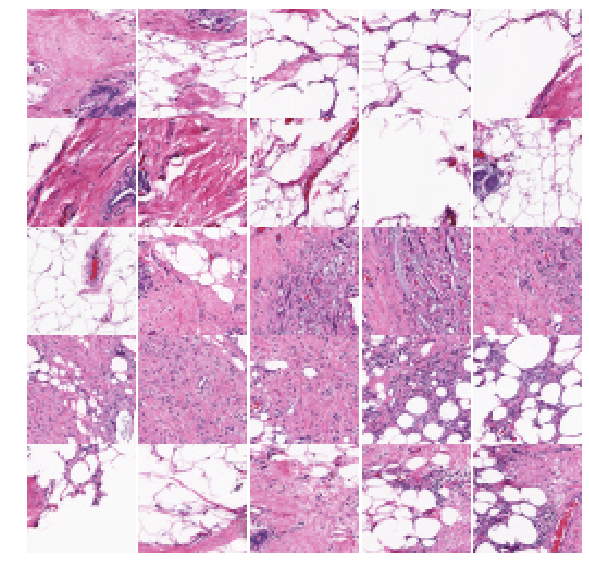

In [9]:
bunchOfImages = imagePatches
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in bunchOfImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (50, 50)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    #plt.show()
    i_ += 1

In [4]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['C:\\Users\\HP\\Desktop\\breast\\IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1001_class0.png', 'C:\\Users\\HP\\Desktop\\breast\\IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1051_class0.png', 'C:\\Users\\HP\\Desktop\\breast\\IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1101_class0.png', 'C:\\Users\\HP\\Desktop\\breast\\IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1151_class0.png', 'C:\\Users\\HP\\Desktop\\breast\\IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1201_class0.png'] 

IDC(+)

 ['C:\\Users\\HP\\Desktop\\breast\\IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y351_class1.png', 'C:\\Users\\HP\\Desktop\\breast\\IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y401_class1.png', 'C:\\Users\\HP\\Desktop\\breast\\IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y301_class1.png', 'C:\\Users\\HP\\Desktop\\breast\\IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y351_class1.png', 'C:\\Users\\HP\\Desktop\\breast\\IDC_regular_ps50_idx5\\10253\\1\\10

In [5]:
from PIL import Image
import numpy
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 25
    HEIGHT = 25
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        
        #im = Image.open(img)
        #np_im = numpy.array(im)
        #x.append(np_im)
        #print (np_im.shape)
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y
X,Y = proc_images(0,120000)
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y
X2=df["images"]
Y2=df["labels"]
X2=np.array(X2)
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1] 

In [6]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)

dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print(df.head(10))
print("")
print(dict_characters)

Total number of images: 120000
Number of IDC(-) Images: 85752
Number of IDC(+) Images: 34248
Percentage of positive images: 28.54%
Image shape (Width, Height, Channels): (15, 15, 3)
                                              images  labels
0  [[[181, 132, 222], [166, 111, 216], [164, 106,...       0
1  [[[190, 137, 221], [191, 146, 218], [183, 130,...       0
2  [[[246, 242, 247], [250, 247, 250], [251, 250,...       0
3  [[[249, 247, 249], [248, 246, 249], [244, 238,...       0
4  [[[243, 233, 242], [248, 246, 249], [250, 248,...       0
5  [[[248, 246, 248], [248, 246, 249], [248, 246,...       0
6  [[[178, 130, 214], [163, 107, 208], [161, 109,...       0
7  [[[205, 181, 201], [249, 247, 250], [251, 250,...       0
8  [[[248, 249, 249], [247, 245, 247], [246, 246,...       0
9  [[[206, 168, 225], [245, 243, 248], [214, 190,...       0

{0: 'IDC(-)', 1: 'IDC(+)'}


In [7]:
X=np.array(X)
X=X/255.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Reduce Sample Size for DeBugging
X_train = X_train[0:300000] 

Y_train = Y_train[0:300000]
X_test = X_test[0:300000] 
Y_test = Y_test[0:300000]

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (96000, 15, 15, 3)
Testing Data Shape: (24000, 15, 15, 3)


In [8]:
Y_trainHot = to_categorical(Y_train, num_classes = 2)
Y_testHot = to_categorical(Y_test, num_classes = 2)

X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

In [9]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#ros = RandomOverSampler(ratio='auto')
ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)

In [10]:
for i in range(len(X_trainRos)):
    height, width, channels = 15,15,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 15,15,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
    
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
print("Old Class Weights: ",class_weight)
from sklearn.utils import class_weight
class_weight2 = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight2)


Old Class Weights:  [0.69976966 1.75144129]
New Class Weights:  [1. 1.]


In [15]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 7, 7, 32)          896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 5, 64)          18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
________

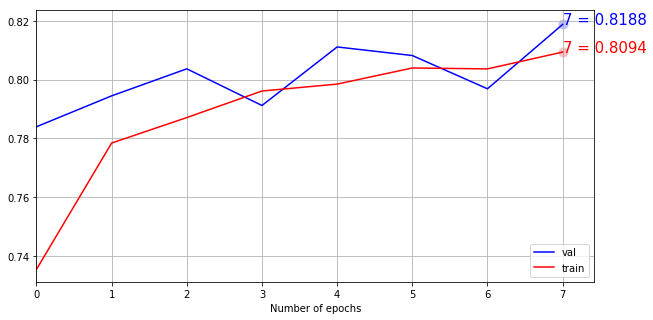

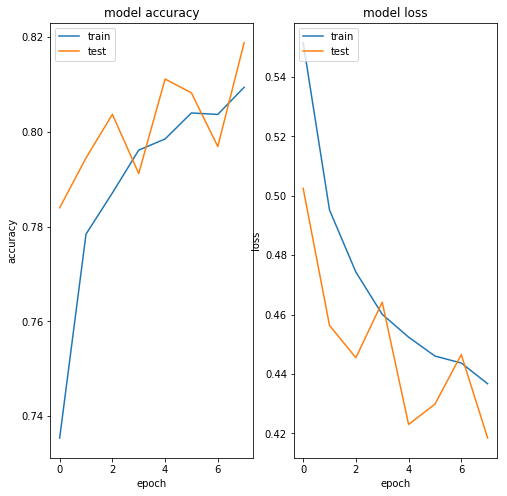

In [18]:
def runKerasCNNAugment(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 128
    num_classes = 2
    epochs = 8
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=15,15
    input_shape = (img_rows, img_cols, 3)
    print(e)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=sgd,
                  metrics=['accuracy'])
    model.summary()
    datagen = ImageDataGenerator(
        featurewise_center=False,   
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=20,  
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        horizontal_flip=True,  
        vertical_flip=True)  
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs,class_weight=f, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

In [2]:
def yetAnotherKeras(a,b,c,d,e,f):
    batch_size=128
    num_classes=2
    epochs=8
    img_rows,img_cols=15,15
    input_shape=(img_rows,img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape,strides=e)) # first layer : convolution
    model.add(MaxPooling2D(pool_size=(2, 2))) # second layer : pooling (reduce the size of the image per 3) 
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid')) # output 1 value between 0 and 1 : probability to have cancer
    model.summary()
    model.compile(loss=keras.losses.binary_crossentropy, # Use binary crossentropy as a loss function  
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    history=model.fit(a,b,
              batch_size=128,
              epochs=epochs,
              verbose=1,
              class_weight=f,
              validation_data = [c,d],
            callbacks = [MetricsCheckpoint('logs')])
    score=model.evaluate(c,d,verbose=0)
    
    
    print('\nKeras CNN #1C- accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    #Y_true = np.argmax(Y_test,axis = 1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)
    
    
    


NameError: name 'X_trainRosReshaped' is not defined

In [12]:
def compareABunchOfDifferentModelsAccuracy(a,b,c,d):
    """
    compare performance of classifiers on X_train, X_test, Y_train, Y_test
    http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
    http://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score
    """    
    print('')
    print('Compare Multiple Classifiers:')
    print('')
    print('K-Fold Cross-Validation Accuracy:')
    print('')
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    
    models.append(('GNB', GaussianNB()))
    models.append(('DTC', DecisionTreeClassifier()))
    models.append(('SVM', SVC()))
    models.append(('LSVM', LinearSVC()))
    #models.append(('GBC', GradientBoostingClassifier()))
    #models.append(('LDA', LinearDiscriminantAnalysis()))       
    resultsAccuracy = []
    names = []
    for name, model in models:
        model.fit(a, b)
        kfold = model_selection.KFold(n_splits=10)
        accuracy_results = model_selection.cross_val_score(model, c, d, cv=kfold, scoring='accuracy')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage)  
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: Accuracy')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('Cross-Validation: Accuracy Score')
    plt.show()
    return
compareABunchOfDifferentModelsAccuracy(X_trainFlat, Y_train, X_testFlat, Y_test)


Compare Multiple Classifiers:

K-Fold Cross-Validation Accuracy:



C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

LR: 0.771000 (0.009822)


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF: 0.798417 (0.008844)


KeyboardInterrupt: 

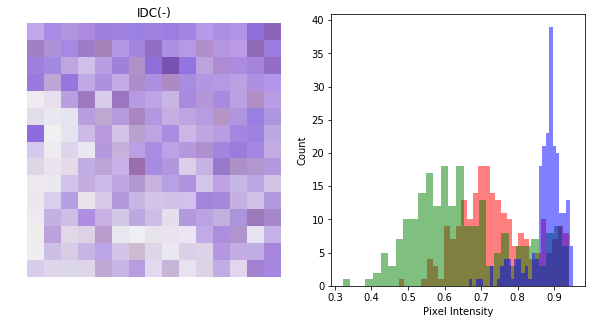

In [7]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('IDC(+)' if Y[1] else 'IDC(-)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[100])

In [13]:
def runLogisticRegression(a,b,c,d):
    """Run LogisticRegression w/ Kfold CV"""
    model = LogisticRegression()
    model.fit(a,b)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
    print(accuracy)
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('LogisticRegression - Training set accuracy: %s (%s)' % (mean, stdev))
    print('')
runLogisticRegression(X_trainFlat, Y_train, X_testFlat, Y_test)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

LogisticRegression - Training set accuracy: 0.771 (0.009821673878610394)



In [14]:
def runLogisticRegression(a,b,c,d):
    """Run LogisticRegression w/ Kfold CV"""
    model =  KNeighborsClassifier()
    model.fit(a,b)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('LogisticRegression - Training set accuracy: %s (%s)' % (mean, stdev))
    print('')
runLogisticRegression(X_trainFlat, Y_train, X_testFlat, Y_test)

LogisticRegression - Training set accuracy: 0.7812500000000001 (0.007658056759605097)



In [37]:
def runLogisticRegression(a,b,c,d):
    
    model =  LogisticRegression()
    model.fit(a,b)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
    recall = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='recall')
    precison = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='precision')
    fi = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='f1')
    
    r=recall.mean()
    p=precison.mean()
    f=fi.mean()
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('LogisticRegression - Training set accuracy: %s  %s %s %s ' % (mean, r,p,f))
    print('')
runLogisticRegression(X_trainFlat, Y_train, X_testFlat, Y_test)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

LogisticRegression - Training set accuracy: 0.7137083333333333  0.0009036315613201509 0.05883699633699633 0.001778124097813313 



In [39]:
def unLogisticRegression(a,b,c,d):
    """Run LogisticRegression w/ Kfold CV"""
    model = RandomForestClassifier()
    model.fit(a,b)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
    recall = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='recall')
    precison = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='precision')
    fi = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='f1')
    
    r=recall.mean()
    p=precison.mean()
    f=fi.mean()
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('LogisticRegression - Training set accuracy: %s  %s %s %s ' % (mean, r,p,f))
    print('')
unLogisticRegression(X_trainFlat, Y_train, X_testFlat, Y_test)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


LogisticRegression - Training set accuracy: 0.8013333333333333  0.49438752868470265 0.7082710290002938 0.5814068562269207 



In [17]:
def runLogisticRegression(a,b,c,d):
    """Run LogisticRegression w/ Kfold CV"""
    model =  SVC()
    model.fit(a,b)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
    print(accuracy)
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('LogisticRegression - Training set accuracy: %s (%s)' % (mean, stdev))
    print('')
runLogisticRegression(X_trainFlat, Y_train, X_testFlat, Y_test)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The defa

KeyboardInterrupt: 